## 0. before work

```
you must run ../data_prepare/data_prepare.ipynb to create rec dataset firstly
and then run this train file
```

## 1. import package and set global var

In [1]:
import mxnet as mx
from mxnet import gluon, image, autograd, nd
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection
from mxnet import metric
from mxnet.gluon import model_zoo

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time

import sys
sys.path.append("../")
from utils.utils import show_9_images, show_images, mkdir_if_not_exist

# dataset root dir
coins_root = "../dataset/"
sdl_root = coins_root + "sdl-coins/"
swiss_root = coins_root + "swiss-coins/"

data_shape = (3, 256, 256)
batch_size = 8
#mean = np.array([ 167.02477919,  157.20263027,  140.25492473])
#std = np.array([ 46.06696734,  47.12624331,  50.81295717])
rgb_mean = np.array([123, 117, 104])

ctx = mx.gpu(0)

## 2. load data and plot data
```
ImageDetIter will call CreateDetAugmenter
if mean==True, it will sub defualt mean
if std==True, it will div default std

both mean and std can not set to False.

or you can cal them and set them as np.array([r, g, b])
```

In [2]:
def get_iterators(rec_prefix, data_shape, batch_size):
    class_names = ['1yuan', '0.5yuan']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix + '_train.rec',
        path_imgidx=rec_prefix + '_train.idx',
        shuffle=True,
        mean=True,
        #std=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    
    valid_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix+'_val.rec',
        shuffle=False,
        mean=True,
        #std=True
    )
    
    return train_iter, valid_iter, class_names, num_class

train_data, valid_data, class_names, num_class = get_iterators(sdl_root+"rec/sdl", data_shape, batch_size)
    

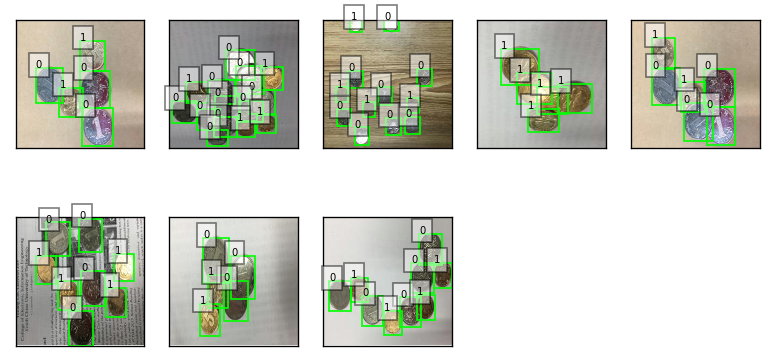

(8L, 14L, 5L)


In [3]:
"""
data plot
"""
mpl.rcParams['figure.dpi'] = 120

train_data.reset()
batch = train_data.next()
images = batch.data[0][:8]
labels = batch.label[0][:8]
show_images(images.asnumpy(), labels.asnumpy(), rgb_mean, show_text=True, fontsize=6)
#show_9_images(images.asnumpy(), labels, rgb_mean)
print labels.shape

## 3.

In [4]:
"""
model define
"""

def get_alexnet_conv(ctx):
    alexnet = model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(alexnet.features[:8]))
    return net

def get_vgg11bn_conv(ctx):
    vgg11bnnet = model_zoo.vision.vgg11_bn(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(vgg11bnnet.features[:21]))
    return net

def down_sample(num_filter):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def class_predictor(num_class, num_anchors):
    return nn.Conv2D(num_anchors * (num_class + 1), kernel_size=3, strides=1, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, strides=1, padding=1)

class SSD(nn.HybridBlock):
    def __init__(self, num_class, sizes_list, ratios_list, ctx, verbose=False, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.num_class = num_class
        self.sizes_list = sizes_list
        self.ratios_list = ratios_list
        self.num_anchors = num_anchors = (len(sizes_list[0]) + len(ratios_list[0]) - 1)
        self.verbose = verbose
        
        with self.name_scope():
            # part 1
#             self.body = nn.HybridSequential()
#             for filters in [16, 32, 64]:
#                 self.body.add(down_sample(filters))
            self.body = get_vgg11bn_conv(ctx)

            # part 2
            self.downsamples = nn.HybridSequential()
            for _ in range(3):
                self.downsamples.add(down_sample(128))

            # part 3
            self.class_predictors = nn.HybridSequential()
            self.box_predictors = nn.HybridSequential()
            for _ in range(5):
                self.class_predictors.add(class_predictor(num_class, num_anchors))
                self.box_predictors.add(box_predictor(num_anchors))
                
            self.downsamples.initialize(ctx=ctx)
            self.class_predictors.initialize(ctx=ctx)
            self.box_predictors.initialize(ctx=ctx)
            
    def hybrid_forward(self, F, x):
        x = self.body(x)
        cls_preds = []
        box_preds = []
        anchors = []
        for i in range(5):
            cls_preds.append((self.class_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            box_preds.append((self.box_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            anchors.append(MultiBoxPrior(x, sizes=self.sizes_list[i], ratios=self.ratios_list[i]))

            if self.verbose:
                print "predict scale", i, x.shape, 'with', anchors[-1].shape, 'anchors'

            if i < 3:
                x = self.downsamples[i](x)
            elif i == 3:
                x = F.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
        cls_preds = nd.concat(*cls_preds, dim=1).reshape((0, -1, num_class+1))
        box_preds = nd.concat(*box_preds, dim=1)
        anchors = nd.concat(*anchors, dim=1)
        return anchors, box_preds, cls_preds

sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5

In [15]:

net = SSD(2, sizes_list, ratios_list, ctx=mx.cpu(), verbose=True, prefix="ssd_")
#net.initialize()
anchors, box_preds, cls_preds = net(batch.data[0])
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, batch.label[0], cls_preds.transpose(axes=(0, 2, 1)))
print cls_labels.shape, cls_preds.shape, box_offset.shape, box_mask.shape

predict scale 0 (8L, 512L, 32L, 32L) with (1L, 4096L, 4L) anchors
predict scale 1 (8L, 128L, 16L, 16L) with (1L, 1024L, 4L) anchors
predict scale 2 (8L, 128L, 8L, 8L) with (1L, 256L, 4L) anchors
predict scale 3 (8L, 128L, 4L, 4L) with (1L, 64L, 4L) anchors
predict scale 4 (8L, 128L, 1L, 1L) with (1L, 4L, 4L) anchors
(8L, 5444L) (8L, 5444L, 3L) (8L, 21776L) (8L, 21776L)


In [11]:
"""
loss define
"""
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gama=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self.alpha = alpha
        self.gama = gama
        self.axis = axis
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label):
        y = F.softmax(y)
        py = y.pick(label, axis=self.axis, keepdims=True)
        loss = - (self.alpha * ((1 - py) ** self.gama)) * py.log()
        return loss.mean(axis=self.batch_axis, exclude=True)
    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label, mask):
        loss = F.smooth_l1((y - label) * mask, scalar=1.0)
        return loss.mean(axis=self.batch_axis, exclude=True)
    
cls_loss = FocalLoss()
#cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
box_loss = SmoothL1Loss()

In [12]:
"""
train net
"""

def evaluate_acc(data_iter):
    data_iter.reset()
    C = 0
    P = 0
    cls_metric = metric.Accuracy()
    box_metric = metric.MAE()
    for i, batch in enumerate(data_iter):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        anchors, box_preds, cls_preds = net(data)
#         cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
#         cls_probs = cls_probs[:, 1:, :]
        box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)), 
                                                          overlap_threshold=0.9)
        cls_metric.update([cls_labels], [cls_preds.transpose((0, 2, 1))])
        box_metric.update([box_offset], [box_preds * box_mask])
    return cls_metric, box_metric
        

def train(net, start_epoch, end_epoch, trainer=None):
    if trainer is None:
        trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.3, 'wd': 5e-4})
    cls_metric = metric.Accuracy()
    box_metric = metric.MAE()
    
    for e in range(start_epoch, end_epoch):
        train_data.reset()
        cls_metric.reset()
        box_metric.reset()
        tic = time.time()
        N = 0
        R = 0
        _loss = [0,0]
        if (e + 1) % 50 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for i, batch in enumerate(train_data):
            data = batch.data[0].as_in_context(ctx)
            label = batch.label[0].as_in_context(ctx)
            with autograd.record():
                anchors, box_preds, cls_preds = net(data)
                box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)),
                                                                  negative_mining_ratio=3.0)#, overlap_threshold=0.75)
                loss1 = cls_loss(cls_preds, cls_labels)
                loss2 = box_loss(box_preds, box_offset, box_mask)
                loss = loss1 + loss2
            loss.backward()
            trainer.step(data.shape[0])
            _loss[0] += nd.mean(loss1).asscalar()
            _loss[1] += nd.mean(loss2).asscalar()
            
            cls_metric.update([cls_labels], [cls_preds.transpose((0, 2, 1))])  # maybe pick axi=1, so change prob to axi 1  
            box_metric.update([box_offset], [box_preds * box_mask])
            
            box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)),
                                                  overlap_threshold=0.75, negative_mining_ratio=3.0)
            N += cls_labels.shape[0] * cls_labels.shape[1] - nd.sum(cls_labels == -1)
            R += nd.sum(cls_labels == cls_preds.argmax(axis=2))
            
        val_cls_metric, val_box_metric = evaluate_acc(valid_data)
        print "epoch", e, "train", cls_metric.get(), box_metric.get(), "time", time.time() - tic
        print "        valid", val_cls_metric.get(), val_box_metric.get(), 'lr', trainer.learning_rate
        print "R / N", (R / N).asscalar(), _loss

net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_")
# net.collect_params().initialize(ctx=ctx, force_reinit=True)
train(net, 0, 100)

epoch 0 train ('accuracy', 0.004772073230467793) ('mae', 0.020251590797367196) time 1.71933293343
        valid ('accuracy', 0.9239300146950772) ('mae', 0.00073178106686100364) lr 0.3
R / N 0.0638889 [1.1069334968924522, 0.15544226532801986]
epoch 1 train ('accuracy', 0.026342073842762676) ('mae', 0.019244048239973683) time 1.58166980743
        valid ('accuracy', 0.9853164033798677) ('mae', 0.00071975769242271781) lr 0.3
R / N 0.0177134 [0.72510773688554764, 0.14627875573933125]
epoch 2 train ('accuracy', 0.04491756980161646) ('mae', 0.019254715375912685) time 1.56863379478
        valid ('accuracy', 0.993811994856723) ('mae', 0.00071239433600567281) lr 0.3
R / N 0.0938486 [0.51903282850980759, 0.14561306918039918]
epoch 3 train ('accuracy', 0.04952508878275778) ('mae', 0.019054092311610777) time 1.57514715195
        valid ('accuracy', 0.9963262307127112) ('mae', 0.00070653320290148258) lr 0.3
R / N 0.293189 [0.38094846159219742, 0.14225951675325632]
epoch 4 train ('accuracy', 0.0508

epoch 34 train ('accuracy', 0.05792883602743081) ('mae', 0.013523183258560797) time 1.59024095535
        valid ('accuracy', 0.9945123071271125) ('mae', 0.00051675419672392309) lr 0.3
R / N 0.577927 [0.067478473065420985, 0.08352701470721513]
epoch 35 train ('accuracy', 0.05487884215037962) ('mae', 0.012387752358336002) time 1.5891559124
        valid ('accuracy', 0.994431943423953) ('mae', 0.00051289095426909626) lr 0.3
R / N 0.602201 [0.061373705975711346, 0.075038647511973977]
epoch 36 train ('accuracy', 0.05491137031594416) ('mae', 0.012232472654432058) time 1.59527587891
        valid ('accuracy', 0.9947419177075679) ('mae', 0.0005119450215715915) lr 0.3
R / N 0.571248 [0.062084911623969674, 0.074216986191459]
epoch 37 train ('accuracy', 0.05670615968650502) ('mae', 0.012530452513601631) time 1.59043908119
        valid ('accuracy', 0.9942023328434975) ('mae', 0.00051161447481717914) lr 0.3
R / N 0.614742 [0.062593636568635702, 0.07559280248824507]
epoch 38 train ('accuracy', 0.05

epoch 68 train ('accuracy', 0.058971650746999754) ('mae', 0.011327828203017512) time 1.61012506485
        valid ('accuracy', 0.992526175606172) ('mae', 0.00048002130642998964) lr 0.03
R / N 0.580918 [0.053847798379138112, 0.064877405297011137]
epoch 69 train ('accuracy', 0.05858705302473671) ('mae', 0.010732021105165282) time 1.58288812637
        valid ('accuracy', 0.9923884092578986) ('mae', 0.00048226211220026016) lr 0.03
R / N 0.573845 [0.04969761916436255, 0.059325556387193501]
epoch 70 train ('accuracy', 0.06096352253245163) ('mae', 0.011418492378046116) time 1.58908605576
        valid ('accuracy', 0.9923654481998531) ('mae', 0.00048297803732566535) lr 0.03
R / N 0.574806 [0.055210953112691641, 0.064465270843356848]
epoch 71 train ('accuracy', 0.056369397501836886) ('mae', 0.010172784192642817) time 1.58429288864
        valid ('accuracy', 0.9921358376193975) ('mae', 0.00048143348249141127) lr 0.03
R / N 0.56281 [0.048225080827251077, 0.056294962298125029]
epoch 72 train ('accu

In [34]:
mkdir_if_not_exist("../models")
net.save_params("../models/sdl_coin_vgg11bn.param")

## 可视化测试结果

In [31]:
sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5
net = SSD(2, sizes_list, ratios_list, verbose=False, prefix="ssd_")
net.initialize(ctx=ctx)
net.load_params("models/sdl_coin1.param", ctx=ctx)

a, b = evaluate_acc(valid_data)
print a.get(), b.get()

('accuracy', 0.9901210389544858) ('mae', 0.011017875891411677)


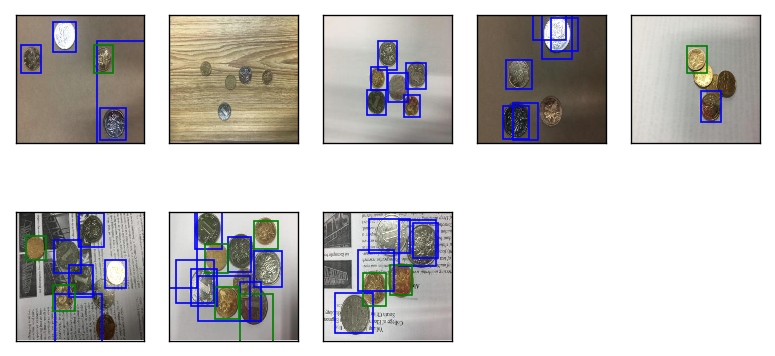

In [36]:
from utils.utils import show_det_results
from mxnet.contrib.ndarray import MultiBoxDetection

mpl.rcParams['figure.figsize'] = (6,6)
valid_data.reset()
batch = valid_data.next()
data = batch.data[0].as_in_context(ctx)
label = batch.label[0].as_in_context(ctx)
anchors, box_preds, cls_preds = net(data)
cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, 
                                                  cls_preds.transpose(axes=(0, 2, 1)))

imgs = data.transpose((0, 2, 3, 1)).asnumpy() + rgb_mean
show_det_results(imgs, out, threshold=0.5, show_text=False)

In [28]:
print nd.sum(cls_labels > 0), nd.mean(cls_labels > 0)


[ 762.]
<NDArray 1 @gpu(0)> 
[ 0.01749633]
<NDArray 1 @gpu(0)>


In [32]:
print (1 - nd.mean(cls_preds.argmax(axis=2) == cls_labels)) * cls_labels.shape[0] *cls_labels.shape[1]


[ 57.0008049]
<NDArray 1 @gpu(0)>


In [40]:
print nd.mean(cls_preds.argmax(axis=2) > 0) * cls_preds.shape[0] * cls_preds.shape[1]


[ 1.]
<NDArray 1 @gpu(0)>


In [67]:
print cls_probs.shape
print out.shape
print out[0, out.shape[1]-1, :]
print cls_probs[0, :, cls_probs.shape[1]-1]
#?? MultiBoxDetection

(8L, 3L, 5444L)
(8L, 5444L, 6L)

[-1. -1. -1. -1. -1. -1.]
<NDArray 6 @gpu(0)>

[ 0.75589293  0.14080909  0.10329798]
<NDArray 3 @gpu(0)>


In [37]:
print nd.mean(out[:, :, 0] >= 0) * out.shape[0] * out.shape[1]


[ 3572.]
<NDArray 1 @gpu(0)>


In [24]:
?? MultiBoxTarget

## 一些确定性测试

In [13]:
sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5
net = SSD(2, sizes_list, ratios_list, verbose=False, prefix="ssd_")
net.initialize(ctx=ctx)
net.load_params("models/sdl_coin1.param", ctx=ctx)

a, b = evaluate_acc(valid_data)
print a.get(), b.get()

valid_data.reset()
batch = valid_data.next()
data = batch.data[0].as_in_context(ctx)
label = batch.label[0].as_in_context(ctx)
anchors, box_preds, cls_preds = net(data)
cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, 
                                                  cls_preds.transpose(axes=(0, 2, 1)), overlap_threshold=0.75)

('accuracy', 0.9900863482692501) ('mae', 0.011260767176281661)


### box_mask是根据cls_label生成的，而不是根据cls_pred生成的

In [22]:
print "acc of pred:", nd.mean(cls_labels == cls_preds.argmax(axis=2)).asscalar()  # acc of pred
print "ratio of neg:", nd.mean(cls_labels == 0).asscalar()                    # ratio of negative data
print "anchor(box_mask) == anchor(cls_label):", nd.mean(box_mask.reshape((0, -1, 4)).transpose((2, 0, 1)) == (cls_labels>0)).asscalar()  # box_mask is generate from label

acc of pred: 0.998991
ratio of neg: 0.999322
anchor(box_mask) == anchor(cls_label): 1.0


### -1表示不使用的数据
```
在MultiBoxTarget输入的box_label中-1就是为了nd.array的对齐而添加的框，不会被使用；
在加入了难反例挖掘的时候，返回的cls_labels中-1就是不使用反例框。
cls_labels中0表示背景类，后面是目标类

MultiBoxDetection返回的检测结果中，-1表示背景框
```

In [28]:
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)), 
                                                  overlap_threshold=0.75, negative_mining_ratio=3.0)
print cls_labels
print "number of used box to class prediction", nd.mean(cls_labels >= 0).asscalar()


[[-1. -1. -1. ...,  0.  0.  0.]
 [-1. -1. -1. ...,  0. -1.  0.]
 [-1. -1. -1. ...,  0. -1.  0.]
 ..., 
 [-1. -1. -1. ...,  0. -1.  0.]
 [-1. -1. -1. ...,  0.  0.  0.]
 [-1. -1. -1. ...,  0. -1.  0.]]
<NDArray 8x39636 @gpu(0)>
number of used box to class prediction 0.00271218
